In [2]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v6 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu 

In [3]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math
import os
import utils
#from utils import plotLearning

#from dueling_dqn_torch import Agent

In [4]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 1.85470306e-03  1.07221614e-10  3.76440282e-03  2.59753018e-11
  1.01102936e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.99999996e-02 -0.00000000e+00  1.10597342e-01 -0.00000000e+00
  0.00000000e+00 -1.91829144e-03  1.00000000e+00  0.00000000e+00
  0.00000000e+00]


In [5]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
    #self.fc4=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
    #x=F.relu(self.fc3(x))
    return actions

In [6]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 10000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    #self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=265, fc2_dims=265)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions 
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
     
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    


    batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
    #batch = np.random.permutation(max_mem)[:self.batch_size]
    #mem = np.array(exp_buffer)[perm_batch]

    #batch=np.random.choice(max_mem,self.batch_size,replace=False)
    batch_index = np.arange(self.batch_size , dtype=np.int32)

    state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch] 
  
    q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
    q_next = self.Q_eval.forward(new_state_batch)

    q_next[terminal_batch] = 0.0
    q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min

In [7]:

class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()

  def step_graph(self,step_list,num_of_eps):
      self.step_list=step_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.step_list)
      plt.xlabel('Episodes')
      plt.ylabel('Steps_to_score')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

dribble prin ton antipalo
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Ball is out by player - 5
---Episode reward: -3.310548954823541 score [0] steps 124 episode= 0 ---
---Avg reward last 10:  -3.310548954823541 Avg score last 10:  0.0 Avg steps 124.0 episode= 0 ---
PROSOXI lathos sprint
antipalos
antipalos
mpala ektos orion
---Episode reward: -3.8543446161855064 score [0] steps 151 episode= 1 ---
PROSOXI lathos sprint
PROSOXI lathos sprint
dribble prin ton antipalo
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
sprint afou exei perasei
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kai sprint NO REWARD
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton 

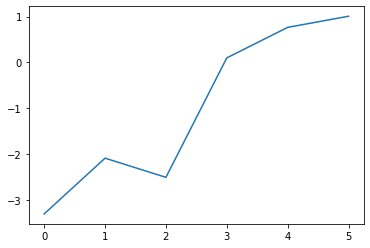

antipalos
dribble prin ton antipalo
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.144365532736972 score [0] steps 103 episode= 51 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -5.058366850120199 score [0] steps 54 episode= 52 ---
goal episode 53 step= 102
---Episode reward: 1.207253844684087 score [1] steps 103 episode= 53 ---
goal episode 54 step= 128
---Episode reward: 1.1540485686605864 score [1] steps 129 episode= 54 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -4.322095605247023 score [0] steps 58 episode= 55 ---
dribble prin ton antipalo
antipalos
PROSOXI lathos sprint
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
per

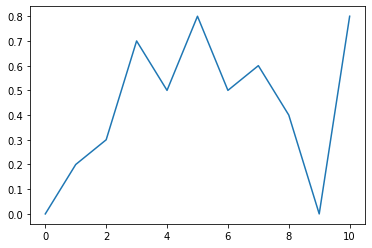

Last 50 episodes avg score 0.46


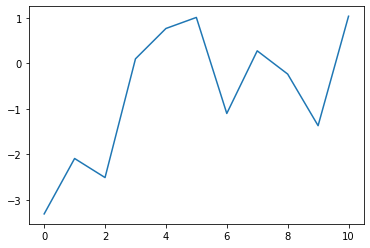

perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
goal episode 101 step= 83
---Episode reward: 3.091007346986448 score [1] steps 84 episode= 101 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
FAUL-SCORE =+1
---Episode reward: -0.2310103631890887 score [1] steps 112 episode= 102 ---
dribble prin ton antipalo
antipalos
antipalos
FAUL-SCORE =+1
---Episode reward: 1.2551608033763586 score [1] steps 109 episode= 103 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kai sprint NO REWARD
perase ton antipalo kanonika
sprint afou exei perasei
perase ton antipalo kai sprint NO REWARD
perase ton antipalo kanonika
perase ton antipalo kai sprint NO REWARD
perase ton antipalo kanonika
perase ton antipalo kai s

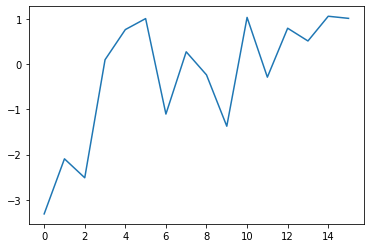

antipalos
antipalos
antipalos
klepsimo
goal episode 151 step= 105
---Episode reward: 0.4238105429588427 score [1] steps 106 episode= 151 ---
FAUL-SCORE =+1
---Episode reward: 1.6748719597402475 score [1] steps 132 episode= 152 ---
goal episode 153 step= 86
---Episode reward: 2.1960650789574574 score [1] steps 87 episode= 153 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.4508964544407403 score [0] steps 78 episode= 154 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -5.056667802749916 score [0] steps 53 episode= 155 ---
goal episode 156 step= 109
---Episode reward: 1.2397304883108438 score [1] steps 110 episode= 156 ---
dribble prin ton antipalo
goal episode 157 step= 129
---Episode reward: 1.6733894224174595 score [1] steps 130 episode= 157 ---
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.0817944613512918 score [1] steps 123 episode= 158 ---
antipalos
an

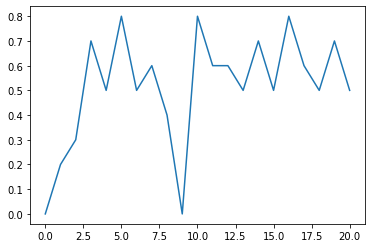

Last 50 episodes avg score 0.62


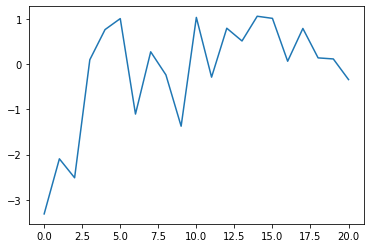

perase ton antipalo kanonika
perase ton antipalo kanonika
goal episode 201 step= 107
---Episode reward: 2.2806199212328075 score [1] steps 108 episode= 201 ---
goal episode 202 step= 112
---Episode reward: 1.2464526836293046 score [1] steps 113 episode= 202 ---
dribble prin ton antipalo
PROSOXI lathos sprint
Mpala piso apo kentro
---Episode reward: 0.19925240815730402 score [0] steps 69 episode= 203 ---
antipalos
antipalos
goal episode 204 step= 105
---Episode reward: 0.5132056531806827 score [1] steps 106 episode= 204 ---
dribble prin ton antipalo
antipalos
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
FAUL-SCORE =+1
PROSOXI lathos sprint
---Episode reward: 2.1857550871330695 score [1] steps 120 episode= 205 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
antipalos
goal episode 206 step= 107
---Episode reward: 2.464436982535899 score [1] steps 108 episode= 206 ---
antipalos
antipalos
antipalos


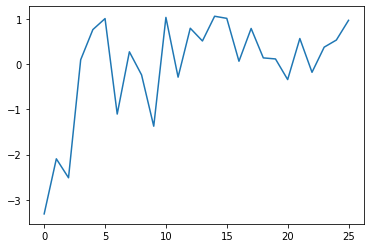

dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 3.122306281307088 score [1] steps 91 episode= 251 ---
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
FAUL-SCORE =+1
---Episode reward: 2.3045166470868925 score [1] steps 119 episode= 252 ---
goal episode 253 step= 109
---Episode reward: 1.2405002420826505 score [1] steps 110 episode= 253 ---
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.4728914136924725 score [1] steps 100 episode= 254 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.9140850981274715 score [0] steps 87 episode= 255 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.

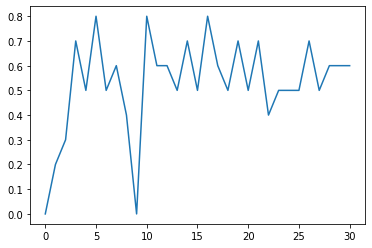

Last 50 episodes avg score 0.6


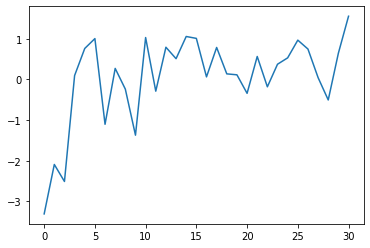

antipalos
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
goal episode 301 step= 94
---Episode reward: 2.023475721038135 score [1] steps 95 episode= 301 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.6754650769416357 score [0] steps 93 episode= 302 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -3.389248619344226 score [0] steps 76 episode= 303 ---
antipalos
antipalos
goal episode 304 step= 94
---Episode reward: 0.2663141763553167 score [1] steps 95 episode= 304 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -5.465031103950093 score [0] steps 54 episode= 305 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
FAUL-SCORE =+1
---Episode reward: -0.7979647396515092 score [1] steps 108 episode= 306 ---
dribble prin ton antipalo
perase ton an

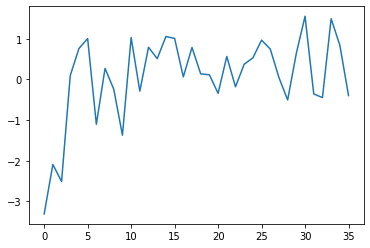

goal episode 351 step= 110
---Episode reward: 1.4980953666722219 score [1] steps 111 episode= 351 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -3.8349880424258522 score [0] steps 63 episode= 352 ---
antipalos
antipalos
antipalos
klepsimo
goal episode 353 step= 104
---Episode reward: -0.7181186502182622 score [1] steps 105 episode= 353 ---
antipalos
antipalos
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
dribble prin ton antipalo
PROSOXI lathos sprint
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -1.53585433785607 score [0] steps 99 episode= 354 ---
antipalos
dribble prin ton antipalo
antipalos
antipalos
klepsimo
ant

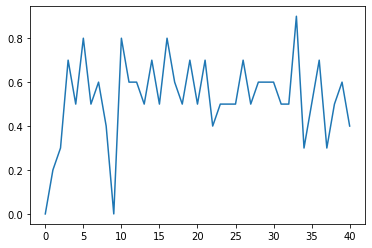

Last 50 episodes avg score 0.5


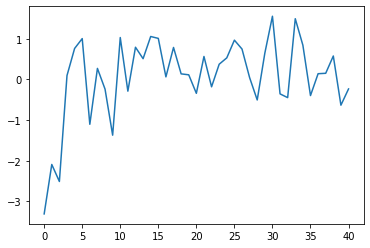

dribble prin ton antipalo
antipalos
perase ton antipalo kanonika
antipalos
antipalos
klepsimo
antipalos
perase ton antipalo kanonika
sprint afou exei perasei
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
mpala ektos orion
---Episode reward: -0.5521558937270511 score [0] steps 80 episode= 401 ---
dribble prin ton antipalo
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
PROSOXI lathos sprint
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
mpala ektos orion
---Episode rew

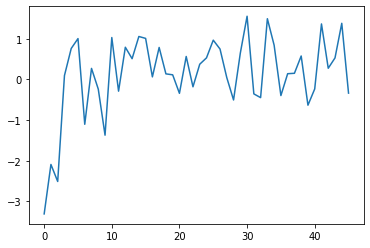

dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.994914825068293 score [1] steps 95 episode= 451 ---
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.4703568801858475 score [1] steps 112 episode= 452 ---
dribble prin ton antipalo
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
FAUL-SCORE =+1
---Episode reward: 2.850256461388369 score [1] steps 122 episode= 453 ---
PROSOXI lathos sprint
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kano

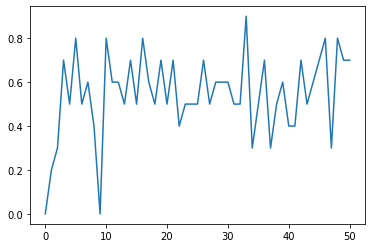

Last 50 episodes avg score 0.66


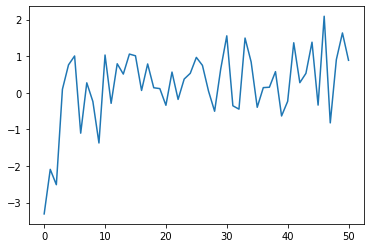

antipalos
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 0.9888697288443727 score [1] steps 132 episode= 501 ---
dribble prin ton antipalo
goal episode 502 step= 119
---Episode reward: 1.8965961169278942 score [1] steps 120 episode= 502 ---
dribble prin ton antipalo
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
perase ton antipalo kanonika
FAUL-SCORE =+1
---Episode reward: 3.5445989399060527 score [1] steps 111 episode= 503 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -1.7562489829144527 score [0] steps 116 episode= 504 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
goal episode 505 step= 110
---Episode reward: 0.45789195277550715 score [1] steps 111 episode= 505 ---

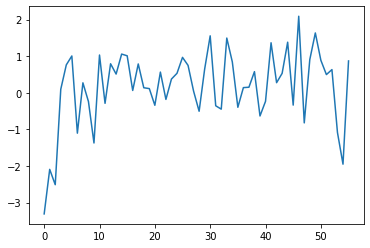

dribble prin ton antipalo
goal episode 551 step= 119
---Episode reward: 2.341128139793882 score [1] steps 120 episode= 551 ---
antipalos
goal episode 552 step= 137
---Episode reward: 1.5353720718499084 score [1] steps 138 episode= 552 ---
goal episode 553 step= 104
---Episode reward: 2.333193832775493 score [1] steps 105 episode= 553 ---
PROSOXI lathos sprint
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.8112915499444684 score [1] steps 101 episode= 554 ---
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.689166395467168 score [1] steps 111 episode= 555 ---
Ball is out by player - 5
---Episode reward: 0.74726288264631 score [0] steps 114 episode= 556 ---
FAUL-SCORE =+1
---Episode reward: 1.2377596683147747 score [1] steps 109 episode= 557 ---
goal episode 558 step= 103
---Episode reward: 2.5499476339600187 score [1] steps 104 episode= 558 ---
mpala ektos orion
---Episode reward: 1.8628520848927386 score [0] steps 89 episode= 559 ---
dribble prin ton antipal

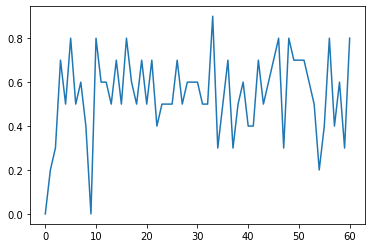

Last 50 episodes avg score 0.58


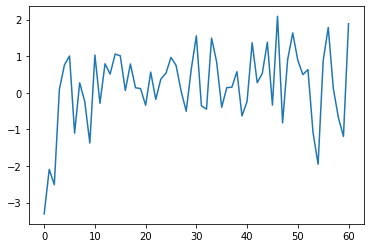

dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
goal episode 601 step= 141
---Episode reward: -0.9679845868715077 score [1] steps 142 episode= 601 ---
dribble prin ton antipalo
antipalos
goal episode 602 step= 105
---Episode reward: 2.5512908867991624 score [1] steps 106 episode= 602 ---
goal episode 603 step= 109
---Episode reward: 1.2404899177637922 score [1] steps 110 episode= 603 ---
dribble prin ton antipalo
FAUL-SCORE =+1
---Episode reward: 2.9785716674994207 score [1] steps 127 episode= 604 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.8334966939039625 score [0] steps 90 episode= 605 ---
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.9604937057759138 score [0] steps 89 episode= 606 ---
antipalos
antipalos
antipalos
klepsimo
goal episode 607 step= 109
---Episode reward: -0.29144705069263893 score [1] steps 110 episode= 607 ---
goal episod

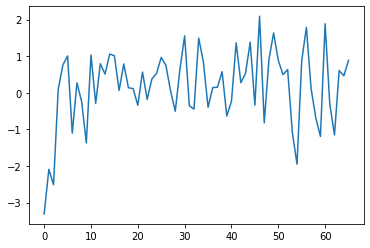

antipalos
antipalos
FAUL-SCORE =+1
---Episode reward: 0.09575083315026207 score [1] steps 119 episode= 651 ---
goal episode 652 step= 112
---Episode reward: 1.8237495379610356 score [1] steps 113 episode= 652 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -2.157872331372159 score [0] steps 96 episode= 653 ---
goal episode 654 step= 105
---Episode reward: 1.6621448404942498 score [1] steps 106 episode= 654 ---
dribble prin ton antipalo
antipalos
antipalos
antipalos
klepsimo
antipalos
antipalos
klepsimo
---Episode reward: -4.916985087161222 score [0] steps 55 episode= 655 ---
goal episode 656 step= 110
---Episode reward: 1.4980953666722219 score [1] steps 111 episode= 656 ---
goal episode 657 step= 105
---Episode reward: 2.4240307259478473 score [1] steps 106 episode= 657 ---
goal episode 658 step= 106
---Episode reward: 2.194135770965268 score [1] steps 107 episode= 658 ---
dribble prin ton antipalo
antipalos
FAUL-SCO

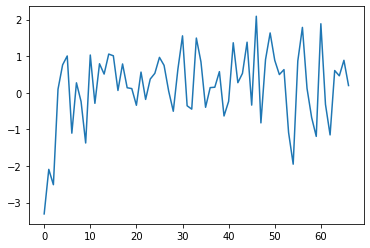

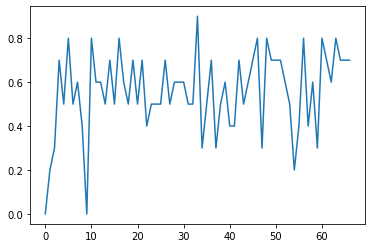

FINAL SCORE PERCENTAGE 0.66


In [8]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 


#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12,13,14,15,17,18]
#print(env.action_space.n)
#Create Objects


agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.0011 ,input_dims= [17], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0 # an skorarei se pano apo enan arithmo paixnidion stamatao tin ekpaideysi 
episode =0
shout =0


num_of_eps = 20001
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
avg_score_list = []
avg_rew_list =[]
steal = []
for i in range(num_of_eps) : 
  score =0 
  done=False 
  eps_rew=0
  observation =env.reset()
  #print("Pinakas apo observations",observation)
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  timer=0 # an klepsei tin mpala kai tin kratisei pano apo 4 steps stamata
  forward=0 #an perasei ton antipalo kai kanei sprint tin proti fora  einai +5
  sprint=0 # an kanei tin proti fora sprint + 20
  dribble =0 # tin proti fora poy kanei dribble na pairnei +10
  fault =0
  checkpoint_reward=[1,1,1,1,1]
  steps=0
  reward =0 

  while not done:

    #CUSTOMIZE ACTIONS HERE 
   
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i) SOSTO
    #print("------------")

    #print(observation[0],observation[1],observation[2],observation[3],observation[4],observation[5])
    

   
     
      
 
    if(act ==0 ): # proti praksi ena bima deksia
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      
      act=1
      #print(new_observation)
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-9s which is index to action list

    #while((observation[4]> observation[0] )  and (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1): #den kanei sprint prin perasei ton paikti
     # action = agent.choose_action(observation)

    #while(observation[4] - observation[0] >0.2 and observation[4]-observation[0]>0 and (Action_list[action]==17 or Action_list[action]==18 )):
     # action = agent.choose_action(observation)

    while((observation[0] > observation[4] +0.02)  and (Action_list[action]==17 or Action_list[action]==18 )): # an ton perasei min kanei drible 
      action = agent.choose_action(observation)
    while((observation[0]<0.65)  and (Action_list[action]==12)): #Den kanei shout ektos periohis
      action = agent.choose_action(observation)
    
     
    #if(observation[0]>observation[4]+0.05  and observation [0] < 0.6):
      #print("perase kai sprint")
      #action = 4

      #print("Player Position:",observation[0],observation[1])
      #print("Player Direction:",observation[2],observation[3])
      #print("Ball Position:",observation[4],observation[5],observation[6])
      #print("Ball Direction:",observation[7],observation[8],observation[9])

    if(shout==0):   #ama kanei shout na min kanei tipota meta 
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        #print("EKANE SHOUT")
        shout=1
    else:
      #print("MPIKE STO ELSE")
      new_observation,reward,done,info = env.step(0)
      action=0 #Ta parakato if den pianoun to Action_list[action]=12 alla gia Action_list[action]=4

#CUSTOM REWARDS-------------------------------
    if(done ==1 and reward ==1): #if agent scores , wins +50
      print("goal","episode",i,"step=",steps)
      reward += 62

   
    if(done ==1 and reward == 0): # an bgei i mpala apo ton antipalo einai -15 , a bgei apo ton paikti einai -5 
      if(shout ==1 ):
        reward = reward - 10
        print("Ball is out by player - 5")
        terminal =0
      else:
        if(observation[9] <0.4 or observation[9] >-0.4 ):
          print("FAUL-SCORE =+1")
          fault =1
          
        else:
          reward = reward -20 #12
          print("ball is out -15","episode",i,"Ball Position",observation[8],observation[9],observation[10],"step=",steps)
          terminal =0



      terminal= terminal +1
      goal_steps.append(steps)


    if(observation[16]==1 ):  # an klepsei tin mpala kai tin kratisei pano apo 4 steps stamata
      print("antipalos")
      timer=timer+1
      reward = reward - 30
      
     
      if(timer == 2 ):
        reward = reward - 40
        
        terminal =0
      if (timer>2 and timer <  4 ):
        reward = reward - 50
        print("klepsimo")
        
      if (timer>4 and timer <6 ):
        reward = reward - 60
        print("klepsimo")
        done =1
      if(timer >= 8):
        done=1
        reward = reward -20
        print("klepsimo")

    if(observation[8]< 0.0 ):  #An i mpala paei piso apo to kentro telos paixnidiou
      print("Mpala piso apo kentro")
      reward = reward-45
      done =1 

    if(observation[9]>0.35 or observation[9]<-0.35):
      reward = reward - 20
      print("mpala ektos orion")
      done = 1

    #----------------
    #if(observation[14]== 0): #an den exo stin katoxi tin mpala einai -5
     # reward =reward-5
    #if(observation[14] == 1): # an exo tin katoxi na einai +2
     #reward =reward +5

    if ((observation[8] > observation[0] + 0.05) and (observation[9] - observation[1] <=0.03) or(observation[9] - observation[1] >=-0.03) ) and Action_list[action]==5: #an kanei deksia kai exei ti mpala
      reward = reward + 5
          
    if (observation[14]!=1):
      reward = reward -5
      #print("mpala oxi dikia moy")
    if(observation[16]==1):
      reward = reward - 10

    if(observation[4] - observation[0] > 0.2 and Action_list[action]==5): # an einai makria o antipalos kai kano bima deksia +2
        reward =reward + 2
    if(observation[4] - observation[0] > 0.2 and (Action_list[action] == 14 or Action_list[action] == 15 or Action_list[action] == 18 )): # an meinei akinitos  einai -2
        reward = reward - 5

    if((observation[0] > observation [4] +0.1) and (Action_list[action]==13)and (observation[14]==1)): #An peraso ton antipalo kai kano sprint tin proti fora +5
      print("perase ton antipalo kai sprint NO REWARD")
      #reward =reward + 10 
    #----------------

    if((observation[4]-observation[0]< 0.05)and dribble==0 and (observation[4]-observation[0]> 0) and (Action_list[action]==17)):  # an kanei dirbble konta ston antipalo prin erthei se ayton +15 
      print("dribble prin ton antipalo")
      if(dribble==0):
        dribble =1
        reward = reward + 10



    if(((observation[0] > observation [4] + 0.05) and observation[14]== 1 ) and done!= 1 and shout ==0 and (observation [0]>-0.2 or observation[0]<0.2)):  # an perasei ton antipalo einai +5
      print("perase ton antipalo kanonika")
      reward = reward + 5
      if(forward ==0):
        forward =1
        reward = reward + 35
      if(Action_list[action]==2):
        reward = reward + 5
      #done =1
      #print(observation)
      
      """if((observation[0]>0.6) and (Action_list[action]==12)) : #an ton perasei kai mpei perioxi kai shoutarei einai + 10
        print("Shout entos periohis")
        reward = reward +15
      #if((observation[0] > observation [4] +0.1) and (Action_list[action]==13) and (sprint ==0)and (observation[14]==1)): # an ton perasei k kanei sprint +5
        #reward = reward + 8
      if((Action_list[action]==13) and (observation[14]==1)): # ton pernaei kai paei deksia 
        reward = reward + 8
      if((Action_list[action]==17) or (Action_list[action]==18) ): # an ton perasei kai kanei drible i stamatisei -20
        print("ton perase kai kanei drible h stamatisei", Action_list[action])
        reward = reward - 20"""

    
    if((observation[4] > observation[0]) and (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1): # an einai apenanti o paiktis kai kano sprint -5
      print("PROSOXI lathos sprint")
      #reward = reward - 10                                     #PROSOXI EDO

    if((observation[4] < observation[0] -0.08)and sprint== 0 and observation[8] <0.65 and done != 1 and shout ==0 and  (Action_list[action]==13 or Action_list[action]==15) and observation[14]==1 and (observation[1]>-0.2 or observation[1]<0.2)):
       reward = reward + 25
       sprint=1
       print("sprint afou exei perasei")
  

    if((observation[0]<0.65)  and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)
      
    if((observation[0]>0.65) and (Action_list[action]==12) and observation[0]<0.75 and observation[0] >observation[4] +0.01 ): #an shoutarei mesa ti megali periohi +10
      reward= reward + 35
      print("shout entos periohis Ball Position",observation[8],observation[9],observation[10],"episode",i,"step=",steps)
    
    #if((observation[0]>0.6) and (Action_list[action]!=12) and observation[0]<0.75 and observation[0] >observation[4] +0.01 ): #an shoutarei mesa ti megali periohi +10
      #reward= reward - 10
    

    
    reward = reward - ( math.sqrt( ((0.935 - observation[8])**2) + (0 -observation[9])**2 ) *0.3) #oso pio makria einai toso perissotero xanei

    #END OF CUSTOM REWARDS ----------------------------- 
 
    
   
    score+= reward/11

    #for prints
    
    #all_prints.print_who_scored(reward)
    
    if(fault==1 and done ==1):
      reward =25
    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    eps_rew += reward

#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  
  #eps_rew+=reward
  step_list.append(steps)
  

  val = info.values()
  list_val=list(val)
  if(fault == 1):
    f=[1]
    list_val =list(f)

  score_list.append(list_val)
  #print(score_list)

  rew_list.append(eps_rew/steps)
  episode = episode +1 

  print("---Episode reward:", eps_rew/steps ,"score",list_val,"steps",steps,"episode=",i,"---")

  #terminate 
  if( np.mean(score_list[-50:]) > 0.62 and (abs(np.mean(score_list[-50:]) - np.mean(score_list[-100:])) < 0.04) and (abs(np.mean(score_list[-100:]) - np.mean(score_list[-200:]))<0.04) and  i>100):
    print("TELOS ekpaideysis")
    break
    

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last 10: ", np.mean(rew_list[-10:]),"Avg score last 10: ",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      avg_score_list.append(np.mean(score_list[-10:]))
      avg_rew_list.append(np.mean(rew_list[-10:]))
      #print(score_list)

  if (((i % 100)== 0) and i!=0) :
      #all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      plt.plot(avg_score_list)
      plt.plot()
      plt.show()
  if(((i%50)==0) and i!=0):
     print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
     #plt.plot(avg_score_list)
     plt.plot(avg_rew_list)
     plt.plot()
     plt.show()
  #if(((i%200)==0) and i!=0):
    #plt.plot(steal)
    #plt.show()
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  #eps_rew=0 #GIA NA BGALO SYNOLIKO GRAFIMA TO AFAIRO AYTO



#print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
#all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
#a = len(goal_steps)
#all_prints.step_graph(goal_steps[-a:],len(goal_steps))
plt.plot(avg_rew_list)
plt.plot()
plt.show()
plt.plot(avg_score_list)
plt.plot()
plt.show()
print("FINAL SCORE PERCENTAGE",np.mean(score_list[-50:]))